HW2  Мельчук А.Б.

Задание на повторение:
Задание не обязательно к выполнению, но очень рекомендуется для понимания набора данных и получения гипотез для проведения валидации.
Задание 1: Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.
Задание 2: построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.
Задание 3: построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.
Задание 4: построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

Основное задание:
Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая.

## Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.

In [1]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

In [8]:
data_train = pd.read_csv("./data/assignment_train.csv")
data_train.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data_test = pd.read_csv("./data/assignment_test.csv")
data_test.head(n=5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3062000,0,1643492,41.0,W,9500,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3062001,1,1643513,161.0,W,6668,390.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3062002,0,1643519,49.0,W,14935,543.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3062003,0,1643519,100.0,R,8394,490.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3062004,0,1643529,97.0,W,9500,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data_train.shape

(50001, 394)

In [11]:
data_train['TransactionID'].nunique()

50001

In [12]:
data_train['isFraud'].value_counts()

0    48644
1     1357
Name: isFraud, dtype: int64

In [13]:
data_train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.000100e+04,50001.000000,5.000100e+04,50001.000000,50001.000000,49304.000000,49998.000000,49766.000000,47410.000000,47410.000000,...,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000
mean,3.012000e+06,0.027139,6.378101e+05,128.129726,9912.598368,366.635547,152.803612,200.704276,291.813162,85.590593,...,0.110450,38.942391,63.051814,45.816241,4.252527,14.926426,7.991718,15.742603,21.362671,16.464481
std,1.443419e+04,0.162491,3.229461e+05,213.078011,4904.597980,159.057800,10.482210,40.299048,104.991697,6.687334,...,0.469788,190.465893,446.405097,210.319262,46.694625,105.561868,60.584452,91.083819,131.071046,92.726771
min,2.987000e+06,0.000000,8.640000e+04,0.292000,1001.000000,100.000000,100.000000,100.000000,100.000000,13.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.999500e+06,0.000000,3.523050e+05,42.000000,6019.000000,208.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.012000e+06,0.000000,6.537500e+05,68.500000,9705.000000,369.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.024500e+06,0.000000,9.321340e+05,120.000000,14265.000000,514.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.037000e+06,1.000000,1.189349e+06,4829.950000,18393.000000,600.000000,229.000000,237.000000,540.000000,102.000000,...,7.000000,6300.000000,32250.000000,6300.000000,1000.000000,2700.000000,1300.000000,1700.000000,3000.000000,1700.000000


In [14]:
train = data_train.loc[data_train['TransactionID'] <= 3024500]
test = data_train.loc[data_train['TransactionID'] > 3024500]

x_train, y_train = train.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), train["isFraud"]
x_test, y_test = test.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), test["isFraud"]

In [15]:
numerical_features = x_train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()

x_train = x_train[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 37501 rows, 377 cols
x_test.shape = 12500 rows, 377 cols


In [16]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
train_score = roc_auc_score(y_train, model.predict(x_train))
test_score = roc_auc_score(y_test, model.predict(x_test))

print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.89, Test-score: 0.656


In [18]:
model = xgb.XGBClassifier(max_depth=12,
                        subsample=0.33,
                        objective='binary:logistic',
                        n_estimators=300,
                        learning_rate = 0.01)
eval_set = [(x_train, y_train), (x_test, y_test)]
model.fit(x_train, y_train, early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.02280	validation_0-logloss:0.68395	validation_1-error:0.02616	validation_1-logloss:0.68400
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.02128	validation_0-logloss:0.67500	validation_1-error:0.02264	validation_1-logloss:0.67510
[2]	validation_0-error:0.02125	validation_0-logloss:0.66623	validation_1-error:0.02064	validation_1-logloss:0.66636
[3]	validation_0-error:0.02149	validation_0-logloss:0.65760	validation_1-error:0.02136	validation_1-logloss:0.65776
[4]	validation_0-error:0.02109	validation_0-logloss:0.64912	validation_1-error:0.02048	validation_1-logloss:0.64928
[5]	validation_0-error:0.02093	validation_0-logloss:0.64082	validation_1-error:0.02008	validation_1-logloss:0.64098
[6]	validation_0-error:0.02131	validation_0-logloss:0.63269	validation_1-error:0.01976	validation_1-logloss:0.63287
[7]	validation_0-error:

[69]	validation_0-error:0.01955	validation_0-logloss:0.31667	validation_1-error:0.01912	validation_1-logloss:0.31878
[70]	validation_0-error:0.01955	validation_0-logloss:0.31366	validation_1-error:0.01928	validation_1-logloss:0.31581
[71]	validation_0-error:0.01949	validation_0-logloss:0.31067	validation_1-error:0.01928	validation_1-logloss:0.31285
[72]	validation_0-error:0.01952	validation_0-logloss:0.30776	validation_1-error:0.01936	validation_1-logloss:0.30993
[73]	validation_0-error:0.01952	validation_0-logloss:0.30487	validation_1-error:0.01928	validation_1-logloss:0.30705
[74]	validation_0-error:0.01952	validation_0-logloss:0.30201	validation_1-error:0.01936	validation_1-logloss:0.30422
[75]	validation_0-error:0.01952	validation_0-logloss:0.29922	validation_1-error:0.01936	validation_1-logloss:0.30142
[76]	validation_0-error:0.01952	validation_0-logloss:0.29642	validation_1-error:0.01920	validation_1-logloss:0.29866
[77]	validation_0-error:0.01952	validation_0-logloss:0.29369	val

[139]	validation_0-error:0.01869	validation_0-logloss:0.17542	validation_1-error:0.01904	validation_1-logloss:0.17963
[140]	validation_0-error:0.01872	validation_0-logloss:0.17412	validation_1-error:0.01904	validation_1-logloss:0.17835
[141]	validation_0-error:0.01867	validation_0-logloss:0.17282	validation_1-error:0.01904	validation_1-logloss:0.17711
[142]	validation_0-error:0.01867	validation_0-logloss:0.17158	validation_1-error:0.01912	validation_1-logloss:0.17591
[143]	validation_0-error:0.01861	validation_0-logloss:0.17034	validation_1-error:0.01912	validation_1-logloss:0.17472
[144]	validation_0-error:0.01867	validation_0-logloss:0.16914	validation_1-error:0.01896	validation_1-logloss:0.17361
[145]	validation_0-error:0.01861	validation_0-logloss:0.16790	validation_1-error:0.01904	validation_1-logloss:0.17245
[146]	validation_0-error:0.01859	validation_0-logloss:0.16670	validation_1-error:0.01912	validation_1-logloss:0.17130
[147]	validation_0-error:0.01848	validation_0-logloss:0.

[209]	validation_0-error:0.01787	validation_0-logloss:0.11229	validation_1-error:0.01928	validation_1-logloss:0.11948
[210]	validation_0-error:0.01787	validation_0-logloss:0.11169	validation_1-error:0.01920	validation_1-logloss:0.11892
[211]	validation_0-error:0.01787	validation_0-logloss:0.11109	validation_1-error:0.01912	validation_1-logloss:0.11839
[212]	validation_0-error:0.01784	validation_0-logloss:0.11050	validation_1-error:0.01912	validation_1-logloss:0.11784
[213]	validation_0-error:0.01781	validation_0-logloss:0.10991	validation_1-error:0.01912	validation_1-logloss:0.11728
[214]	validation_0-error:0.01781	validation_0-logloss:0.10932	validation_1-error:0.01904	validation_1-logloss:0.11672
[215]	validation_0-error:0.01781	validation_0-logloss:0.10876	validation_1-error:0.01904	validation_1-logloss:0.11620
[216]	validation_0-error:0.01781	validation_0-logloss:0.10820	validation_1-error:0.01904	validation_1-logloss:0.11573
[217]	validation_0-error:0.01784	validation_0-logloss:0.

[279]	validation_0-error:0.01659	validation_0-logloss:0.08127	validation_1-error:0.01968	validation_1-logloss:0.09213
[280]	validation_0-error:0.01648	validation_0-logloss:0.08094	validation_1-error:0.01968	validation_1-logloss:0.09186
[281]	validation_0-error:0.01648	validation_0-logloss:0.08065	validation_1-error:0.01968	validation_1-logloss:0.09162
[282]	validation_0-error:0.01645	validation_0-logloss:0.08035	validation_1-error:0.01968	validation_1-logloss:0.09135
[283]	validation_0-error:0.01645	validation_0-logloss:0.08007	validation_1-error:0.01960	validation_1-logloss:0.09108
[284]	validation_0-error:0.01645	validation_0-logloss:0.07978	validation_1-error:0.01968	validation_1-logloss:0.09079
[285]	validation_0-error:0.01643	validation_0-logloss:0.07947	validation_1-error:0.01960	validation_1-logloss:0.09054
[286]	validation_0-error:0.01637	validation_0-logloss:0.07917	validation_1-error:0.01968	validation_1-logloss:0.09030
[287]	validation_0-error:0.01643	validation_0-logloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.33,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [19]:
y_pred = model.predict(x_test)
predictions_test = [round(value) for value in y_pred]

y_pred = model.predict(x_train)
predictions_train = [round(value) for value in y_pred]

In [20]:
roc_auc = roc_auc_score(y_test, predictions_test)
print(f"roc_auc score on test =  {roc_auc}")

roc_auc = roc_auc_score(y_train, predictions_train)
print(f"roc_auc score on train =  {roc_auc}")

roc_auc score on test =  0.6008037175590367
roc_auc score on train =  0.7213935591152669


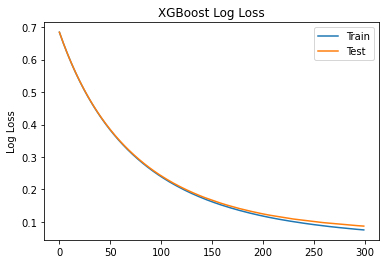

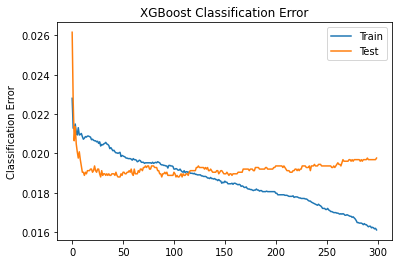

In [21]:
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

# Расхождение значения метрики на обучающем и тестовом датасетах сильно расходится. И по графики видно как пересекаются графики ошибок классификации. Можно сделать вовод, что после 100 деревьев наступает переобучение модели

## Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

In [22]:
data_train['TransactionID'].quantile(0.9)

3032000.0

In [23]:
train = data_train.loc[data_train['TransactionID'] <= 3024500]
valid = data_train.loc[(data_train['TransactionID'] > 3024500) & (data_train['TransactionID'] <= 3032000)]
test = data_train.loc[data_train['TransactionID'] > 3032000]

x_train, y_train = train.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), train["isFraud"]
x_valid, y_valid = valid.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), valid["isFraud"]
x_test, y_test = test.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), test["isFraud"]

In [24]:
x_train = x_train[numerical_features]
x_valid = x_valid[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 37501 rows, 377 cols
x_valid.shape = 7500 rows, 377 cols
x_test.shape = 5000 rows, 377 cols


In [25]:
model = xgb.XGBClassifier(max_depth=12,
                        subsample=0.33,
                        objective='binary:logistic',
                        n_estimators=300,
                        learning_rate = 0.01)
eval_set = [(x_train, y_train), (x_valid, y_valid)]
model.fit(x_train, y_train, early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.02280	validation_0-logloss:0.68395	validation_1-error:0.02787	validation_1-logloss:0.68403
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.02128	validation_0-logloss:0.67500	validation_1-error:0.02453	validation_1-logloss:0.67520
[2]	validation_0-error:0.02125	validation_0-logloss:0.66623	validation_1-error:0.02280	validation_1-logloss:0.66649
[3]	validation_0-error:0.02149	validation_0-logloss:0.65760	validation_1-error:0.02280	validation_1-logloss:0.65790
[4]	validation_0-error:0.02109	validation_0-logloss:0.64912	validation_1-error:0.02160	validation_1-logloss:0.64945
[5]	validation_0-error:0.02093	validation_0-logloss:0.64082	validation_1-error:0.02147	validation_1-logloss:0.64119
[6]	validation_0-error:0.02131	validation_0-logloss:0.63269	validation_1-error:0.02093	validation_1-logloss:0.63313
[7]	validation_0-error:

[69]	validation_0-error:0.01955	validation_0-logloss:0.31667	validation_1-error:0.02040	validation_1-logloss:0.32058
[70]	validation_0-error:0.01955	validation_0-logloss:0.31366	validation_1-error:0.02067	validation_1-logloss:0.31761
[71]	validation_0-error:0.01949	validation_0-logloss:0.31067	validation_1-error:0.02080	validation_1-logloss:0.31468
[72]	validation_0-error:0.01952	validation_0-logloss:0.30776	validation_1-error:0.02080	validation_1-logloss:0.31178
[73]	validation_0-error:0.01952	validation_0-logloss:0.30487	validation_1-error:0.02067	validation_1-logloss:0.30892
[74]	validation_0-error:0.01952	validation_0-logloss:0.30201	validation_1-error:0.02080	validation_1-logloss:0.30610
[75]	validation_0-error:0.01952	validation_0-logloss:0.29922	validation_1-error:0.02080	validation_1-logloss:0.30332
[76]	validation_0-error:0.01952	validation_0-logloss:0.29642	validation_1-error:0.02053	validation_1-logloss:0.30057
[77]	validation_0-error:0.01952	validation_0-logloss:0.29369	val

[139]	validation_0-error:0.01869	validation_0-logloss:0.17542	validation_1-error:0.02040	validation_1-logloss:0.18243
[140]	validation_0-error:0.01872	validation_0-logloss:0.17412	validation_1-error:0.02040	validation_1-logloss:0.18116
[141]	validation_0-error:0.01867	validation_0-logloss:0.17282	validation_1-error:0.02040	validation_1-logloss:0.17993
[142]	validation_0-error:0.01867	validation_0-logloss:0.17158	validation_1-error:0.02040	validation_1-logloss:0.17874
[143]	validation_0-error:0.01861	validation_0-logloss:0.17034	validation_1-error:0.02040	validation_1-logloss:0.17756
[144]	validation_0-error:0.01867	validation_0-logloss:0.16914	validation_1-error:0.02040	validation_1-logloss:0.17648
[145]	validation_0-error:0.01861	validation_0-logloss:0.16790	validation_1-error:0.02040	validation_1-logloss:0.17533
[146]	validation_0-error:0.01859	validation_0-logloss:0.16670	validation_1-error:0.02040	validation_1-logloss:0.17418
[147]	validation_0-error:0.01848	validation_0-logloss:0.

[209]	validation_0-error:0.01787	validation_0-logloss:0.11229	validation_1-error:0.02067	validation_1-logloss:0.12285
[210]	validation_0-error:0.01787	validation_0-logloss:0.11169	validation_1-error:0.02067	validation_1-logloss:0.12230
[211]	validation_0-error:0.01787	validation_0-logloss:0.11109	validation_1-error:0.02053	validation_1-logloss:0.12177
[212]	validation_0-error:0.01784	validation_0-logloss:0.11050	validation_1-error:0.02053	validation_1-logloss:0.12126
[213]	validation_0-error:0.01781	validation_0-logloss:0.10991	validation_1-error:0.02053	validation_1-logloss:0.12072
[214]	validation_0-error:0.01781	validation_0-logloss:0.10932	validation_1-error:0.02053	validation_1-logloss:0.12016
[215]	validation_0-error:0.01781	validation_0-logloss:0.10876	validation_1-error:0.02053	validation_1-logloss:0.11964
[216]	validation_0-error:0.01781	validation_0-logloss:0.10820	validation_1-error:0.02053	validation_1-logloss:0.11918
[217]	validation_0-error:0.01784	validation_0-logloss:0.

[279]	validation_0-error:0.01659	validation_0-logloss:0.08127	validation_1-error:0.02133	validation_1-logloss:0.09592
[280]	validation_0-error:0.01648	validation_0-logloss:0.08094	validation_1-error:0.02133	validation_1-logloss:0.09564
[281]	validation_0-error:0.01648	validation_0-logloss:0.08065	validation_1-error:0.02133	validation_1-logloss:0.09540
[282]	validation_0-error:0.01645	validation_0-logloss:0.08035	validation_1-error:0.02133	validation_1-logloss:0.09514
[283]	validation_0-error:0.01645	validation_0-logloss:0.08007	validation_1-error:0.02120	validation_1-logloss:0.09487
[284]	validation_0-error:0.01645	validation_0-logloss:0.07978	validation_1-error:0.02133	validation_1-logloss:0.09461
[285]	validation_0-error:0.01643	validation_0-logloss:0.07947	validation_1-error:0.02120	validation_1-logloss:0.09437
[286]	validation_0-error:0.01637	validation_0-logloss:0.07917	validation_1-error:0.02133	validation_1-logloss:0.09413
[287]	validation_0-error:0.01643	validation_0-logloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.33,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
y_pred = model.predict(x_test)
predictions_test = [round(value) for value in y_pred]

y_pred = model.predict(x_train)
predictions_train = [round(value) for value in y_pred]

In [27]:
roc_auc = roc_auc_score(y_test, predictions_test)
print(f"roc_auc score on test =  {roc_auc}")

roc_auc = roc_auc_score(y_train, predictions_train)
print(f"roc_auc score on train =  {roc_auc}")

roc_auc score on test =  0.5582015963423612
roc_auc score on train =  0.7213935591152669


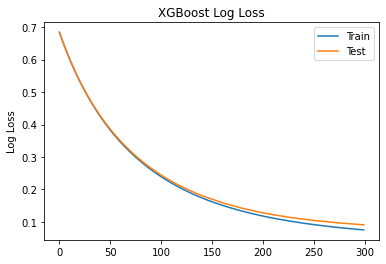

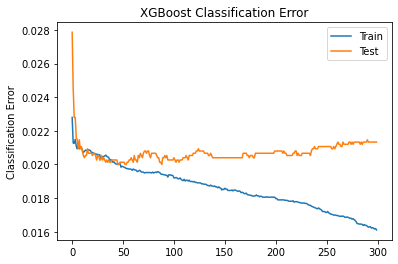

In [28]:
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

# В этом примере ошибка классификации расходится ещё более значительно, и переобучение происходит раньше.

## Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на тестовом выборке относительно полученного доверительного интервала. Сделать выводы.

In [29]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [30]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test, model.predict(x_test), roc_auc_score)

calculate_confidence_interval(scores)

(0.5227617454324894, 0.5911739110107568)

# Значение целевой метрики на тестовом датасете составляло 0.5582, что находится посреди доверительного интервала. Сам по себе интервал получился достаточно узким

## Задание 4: выполнить Adversarial Validation на основе данных из обучения / теста, подобрать объема из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах.

In [31]:
X = data_train[numerical_features]
y = data_train['isFraud']

In [32]:
skf = StratifiedKFold(n_splits=5)
scores = []
for train_index, test_index in skf.split(X, y):
    model = xgb.XGBClassifier()
    model.fit(X.iloc[train_index], y.iloc[train_index])
    train_score = roc_auc_score(y.iloc[train_index], model.predict(X.iloc[train_index]))
    test_score = roc_auc_score(y.iloc[test_index], model.predict(X.iloc[test_index]))

    print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}")
    scores.append(test_score)

Train-score: 0.883, Test-score: 0.64
Train-score: 0.883, Test-score: 0.652
Train-score: 0.894, Test-score: 0.709
Train-score: 0.89, Test-score: 0.687
Train-score: 0.894, Test-score: 0.641


In [33]:
print(f"CV-results: {round(np.mean(scores), 4)} +/- {round(np.std(scores), 3)}")

CV-results: 0.6659 +/- 0.027


## Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных;



In [210]:
target, data = train["isFraud"], prepare_data(train, categorical=categorical, to_drop=to_drop)

In [211]:
_, oof_score, train_scores, valid_scores, oof_preds = make_cross_validation(
    data, target, params=cb_params_1000, metric=roc_auc_score, cv_strategy=cv
)

0:	test: 0.6110779	best: 0.6110779 (0)	total: 79.4ms	remaining: 1m 19s
10:	test: 0.6947471	best: 0.6950199 (8)	total: 813ms	remaining: 1m 13s
20:	test: 0.7645495	best: 0.7645495 (20)	total: 1.39s	remaining: 1m 4s
30:	test: 0.7806753	best: 0.7832543 (22)	total: 1.96s	remaining: 1m 1s
40:	test: 0.7883452	best: 0.7890580 (36)	total: 2.78s	remaining: 1m 4s
50:	test: 0.8005510	best: 0.8017917 (49)	total: 3.65s	remaining: 1m 7s
60:	test: 0.8084877	best: 0.8090298 (58)	total: 4.47s	remaining: 1m 8s
70:	test: 0.8181719	best: 0.8183010 (67)	total: 5.14s	remaining: 1m 7s
80:	test: 0.8212953	best: 0.8212953 (80)	total: 5.78s	remaining: 1m 5s
90:	test: 0.8255941	best: 0.8258948 (87)	total: 6.39s	remaining: 1m 3s
100:	test: 0.8306364	best: 0.8306364 (100)	total: 6.95s	remaining: 1m 1s
110:	test: 0.8339922	best: 0.8339922 (110)	total: 7.55s	remaining: 1m
120:	test: 0.8393023	best: 0.8393023 (120)	total: 8.39s	remaining: 1m
130:	test: 0.8433822	best: 0.8433822 (130)	total: 9.06s	remaining: 1m
140:	te

100:	test: 0.8271938	best: 0.8271938 (100)	total: 7.48s	remaining: 1m 6s
110:	test: 0.8299541	best: 0.8301056 (109)	total: 8.19s	remaining: 1m 5s
120:	test: 0.8385775	best: 0.8385775 (120)	total: 8.87s	remaining: 1m 4s
130:	test: 0.8406098	best: 0.8406098 (130)	total: 9.61s	remaining: 1m 3s
140:	test: 0.8433579	best: 0.8433579 (140)	total: 10.4s	remaining: 1m 3s
150:	test: 0.8469818	best: 0.8470946 (149)	total: 11.1s	remaining: 1m 2s
160:	test: 0.8507049	best: 0.8507939 (159)	total: 11.9s	remaining: 1m 1s
170:	test: 0.8528525	best: 0.8528525 (170)	total: 12.6s	remaining: 1m 1s
180:	test: 0.8544792	best: 0.8544792 (180)	total: 13.3s	remaining: 1m
190:	test: 0.8558325	best: 0.8558325 (190)	total: 14s	remaining: 59.4s
200:	test: 0.8573702	best: 0.8573702 (200)	total: 14.8s	remaining: 58.7s
210:	test: 0.8584019	best: 0.8584809 (209)	total: 15.5s	remaining: 57.9s
220:	test: 0.8594472	best: 0.8594634 (218)	total: 16.3s	remaining: 57.4s
230:	test: 0.8604278	best: 0.8604278 (230)	total: 17s	re

190:	test: 0.8571440	best: 0.8571440 (190)	total: 14.5s	remaining: 1m 1s
200:	test: 0.8590534	best: 0.8590534 (200)	total: 15.3s	remaining: 1m
210:	test: 0.8607644	best: 0.8607644 (210)	total: 16s	remaining: 59.7s
220:	test: 0.8620257	best: 0.8620257 (220)	total: 16.7s	remaining: 58.9s
230:	test: 0.8623906	best: 0.8624674 (229)	total: 17.4s	remaining: 58.1s
240:	test: 0.8632825	best: 0.8633503 (236)	total: 18.2s	remaining: 57.4s
250:	test: 0.8637317	best: 0.8638211 (247)	total: 18.9s	remaining: 56.5s
260:	test: 0.8645143	best: 0.8645143 (260)	total: 19.6s	remaining: 55.6s
270:	test: 0.8653556	best: 0.8653556 (270)	total: 20.4s	remaining: 54.8s
280:	test: 0.8660230	best: 0.8660230 (280)	total: 21.1s	remaining: 53.9s
290:	test: 0.8666074	best: 0.8666074 (290)	total: 21.8s	remaining: 53.1s
300:	test: 0.8675453	best: 0.8675688 (299)	total: 22.5s	remaining: 52.3s
310:	test: 0.8675935	best: 0.8676135 (309)	total: 23.2s	remaining: 51.5s
320:	test: 0.8682501	best: 0.8682944 (319)	total: 24s	re

280:	test: 0.8594879	best: 0.8594879 (280)	total: 19.8s	remaining: 50.7s
290:	test: 0.8602693	best: 0.8602693 (290)	total: 20.5s	remaining: 50s
300:	test: 0.8607261	best: 0.8607261 (300)	total: 21.2s	remaining: 49.3s
310:	test: 0.8615931	best: 0.8615931 (310)	total: 21.9s	remaining: 48.5s
320:	test: 0.8619676	best: 0.8619676 (320)	total: 22.6s	remaining: 47.9s
330:	test: 0.8628805	best: 0.8628805 (330)	total: 23.3s	remaining: 47.1s
340:	test: 0.8631922	best: 0.8631922 (340)	total: 24s	remaining: 46.4s
350:	test: 0.8640493	best: 0.8640493 (350)	total: 24.8s	remaining: 45.9s
360:	test: 0.8644300	best: 0.8644300 (360)	total: 25.6s	remaining: 45.3s
370:	test: 0.8648968	best: 0.8649484 (369)	total: 26.3s	remaining: 44.6s
380:	test: 0.8655161	best: 0.8655161 (380)	total: 27s	remaining: 43.9s
390:	test: 0.8660705	best: 0.8660705 (390)	total: 27.7s	remaining: 43.2s
400:	test: 0.8664675	best: 0.8664675 (400)	total: 28.4s	remaining: 42.4s
410:	test: 0.8674977	best: 0.8674977 (410)	total: 29.1s	r

370:	test: 0.8657465	best: 0.8657465 (370)	total: 26.6s	remaining: 45.2s
380:	test: 0.8659466	best: 0.8659483 (373)	total: 27.3s	remaining: 44.4s
390:	test: 0.8668207	best: 0.8668207 (390)	total: 28.1s	remaining: 43.7s
400:	test: 0.8668662	best: 0.8668901 (398)	total: 28.8s	remaining: 43s
410:	test: 0.8670736	best: 0.8670736 (410)	total: 29.5s	remaining: 42.2s
420:	test: 0.8678076	best: 0.8678076 (420)	total: 30.2s	remaining: 41.5s
430:	test: 0.8683599	best: 0.8683599 (430)	total: 30.9s	remaining: 40.8s
440:	test: 0.8689273	best: 0.8689273 (440)	total: 31.6s	remaining: 40.1s
450:	test: 0.8692863	best: 0.8692863 (450)	total: 32.3s	remaining: 39.3s
460:	test: 0.8695890	best: 0.8695890 (460)	total: 33s	remaining: 38.6s
470:	test: 0.8698598	best: 0.8698598 (470)	total: 33.7s	remaining: 37.8s
480:	test: 0.8703367	best: 0.8703374 (479)	total: 34.4s	remaining: 37.1s
490:	test: 0.8707847	best: 0.8707847 (490)	total: 35.1s	remaining: 36.4s
500:	test: 0.8712097	best: 0.8712097 (500)	total: 35.8s

In [213]:
y_pred_lb = 0
test_ = prepare_data(test, categorical=categorical, to_drop=to_drop)

for estimator in _:
    y_pred_lb += estimator.predict_proba(test_)[:, 1]

y_pred_lb = y_pred_lb / 5

In [214]:
score = roc_auc_score(test["isFraud"], y_pred_lb)
print(score)

0.8673011754952537


Задание 6 * (опциональное): сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на тестовой выборке с полученным доверительным интервалом. Сделать выводы.

Задание 7 ** (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).